## Building Classifier Models

In [8]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
#from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score

import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.utils import resample
import gc



sns.set_style('darkgrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Spliting and Upsampling training set

In [39]:
df = pd.read_csv("app_train_dummy.csv")
df.drop(columns= ['Unnamed: 0'], inplace = True)
df.head(3)

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_0,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",EMERGENCYSTATE_MODE_0,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET,SK_ID_CURR
0,0,0,0,0,202500.0,406597.5,24700.5,0.018801,-9461,-637.0,...,0,0,0,0,1,0,1,0,1,100002
1,1,0,1,0,270000.0,1293502.5,35698.5,0.003541,-16765,-1188.0,...,0,0,1,0,0,0,1,0,0,100003
2,0,1,0,0,67500.0,135000.0,6750.0,0.010032,-19046,-225.0,...,0,1,0,0,0,1,0,0,0,100004


In [20]:
np.all(np.isfinite(df))

False

For some reason, when I read from the csv file, the dataframe contains some of infinite values which make the Logistic Regression Model cannot be trained. Then I replace the infinite values by NaN values and then replace NaNs by zeros.

In [40]:
df = df.replace([np.inf, -np.inf], np.nan)
df.fillna(0, inplace = True)
np.all(np.isfinite(df))

True

In [67]:
df.shape

(307507, 298)

In [42]:
y = df['TARGET'].values
X = df.drop(columns= ['SK_ID_CURR','TARGET'])

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [11]:
# Upsampling only training set

# combine X_train, y_train into one dataframe

X_train['TARGET'] = y_train
X_train['TARGET'].value_counts()

C:\Users\HaNguyen\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


0    212061
1     18569
Name: TARGET, dtype: int64

In [15]:
from sklearn.utils import resample

# Separate majority and minority classes
X_train_majority = X_train[X_train.TARGET==0]
X_train_minority = X_train[X_train.TARGET==1]

# Upsample minority class
X_train_minority_upsampled = resample(X_train_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples= 212061,    # to match majority class
                                 random_state=99) # reproducible results
 
# Combine majority class with upsampled minority class
X_train_upsampled = pd.concat([X_train_majority, X_train_minority_upsampled])
 
# Display new class counts
X_train_upsampled.TARGET.value_counts()

X_train_upsampled.to_csv("X_train_upsampled.csv")


X_test['TARGET'] = y_test
X_test.to_csv("test.csv")

C:\Users\HaNguyen\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [17]:
X_train_upsampled['TARGET'].value_counts()

1    212061
0    212061
Name: TARGET, dtype: int64

In [20]:
y_test.value_counts()

0    70621
1     6256
Name: TARGET, dtype: int64

In [18]:
y_train = X_train_upsampled['TARGET']
y_test = X_test["TARGET"]
X_train = X_train_upsampled.drop(columns= ['TARGET'])
X_test = X_test.drop(columns= ['TARGET'])

In [7]:
# when scrashing, re-read from csv files
X_train_upsampled= pd.read_csv("X_train_upsampled.csv")
X_test = pd.read_csv("test.csv")
X_train_upsampled.drop(columns= ['Unnamed: 0'], inplace = True)
X_test.drop(columns= ['Unnamed: 0'], inplace = True)
y_train = X_train_upsampled['TARGET']
y_test = X_test["TARGET"]

In [9]:
X_train = X_train_upsampled.drop(columns= ['TARGET'])
X_test = X_test.drop(columns= ['TARGET'])

In [10]:
X_train_upsampled['TARGET'].value_counts()

1    212061
0    212061
Name: TARGET, dtype: int64

In [11]:
y_test.value_counts()

0    70621
1     6256
Name: TARGET, dtype: int64

## Logistic Regression Model

In [13]:
# Create a scaler object
# centering data, mean ~ 0, std ~ 1
sc = StandardScaler()

# Fit the scaler to the training data and transform
X_train_std = sc.fit_transform(X_train)

# Apply the scaler to the test data
X_test_std = sc.transform(X_test)


In [6]:
'''
# Normalization with MinMaxScaler
# prefer use of StandardScaler
scaler = MinMaxScaler(feature_range = (0, 1))
 
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)
'''

In [15]:
# NOT using GridSearchCV
# print out time
# start = time.time()

import time
start = time.time()

log_reg_1  = LogisticRegression(penalty='l1', C=0.0001)

log_reg_1.fit(X_train_std, y_train)

print("Logistic Regression with l1 and c = 0.0001 takes " ,time.time() - start, " seconds to run")

# AUC_ROC score on test set only
score_log_reg = roc_auc_score(y_test, log_reg_1.predict(X_test_std))
print("AUC_ROC score using Logistic Regression with l1 and 0.0001: {:.3f}" .format(score_log_reg))

# we dont use accuracy score as the test set is still imbalance and the accuracy score is affected by the imbalance
# print('Training accuracy:', log_reg.score(X_train_sc, y_train))
# print('Test accuracy:', log_reg.score(X_test_sc, y_test))  

Logistic Regression with l1 and c = 0.0001 takes  162.05123686790466  seconds to run
AUC_ROC score using Logistic Regression with l1 and 0.0001: 0.667


**Logistic Regression penalty = l1, C = 0.001**

In [16]:
gc.collect()
start = time.time()

log_reg_2  = LogisticRegression(penalty='l1', C=0.001)

log_reg_2.fit(X_train_std, y_train)

print("Logistic Regression with penalty l1 and C = 0.001 takes " ,time.time() - start, " seconds to run")

score_log_reg_2 = roc_auc_score(y_test, log_reg_2.predict(X_test_std))
print("AUC_ROC score using Logistic Regression with l1 and C = 0.001: {:.3f}" .format(score_log_reg_2))

Logistic Regression with penalty l1 and C = 0.001 takes  152.859046459198  seconds to run
AUC_ROC score using Logistic Regression with l1 and C = 0.001: 0.694


**Logistic Regression penalty = l1, C = 0.01**

In [21]:
gc.collect()
start = time.time()

log_reg_3  = LogisticRegression(penalty='l1', C=0.01)

log_reg_3.fit(X_train_std, y_train)

print("Logistic Regression with penalty l1 and C = 0.01 takes " ,time.time() - start, " seconds to run")

score_log_reg_3 = roc_auc_score(y_test, log_reg_3.predict(X_test_std))
print("AUC_ROC score using Logistic Regression with l1 and C=0.01: ", score_log_reg_3)

Logistic Regression with penalty l1 and C = 0.01 takes  778.6405324935913  seconds to run
AUC_ROC score using Logistic Regression with l1 and C=0.01:  0.693764798158362


**Logistic Regression penalty = l2, C = 0.0001**

In [14]:
gc.collect()
start = time.time()

log_reg_4  = LogisticRegression(penalty='l2', C=0.0001)

log_reg_4.fit(X_train_std, y_train)

print("Logistic Regression with penalty l2 and C = 0.0001 takes " ,time.time() - start, " seconds to run")

score_log_reg_4 = roc_auc_score(y_test, log_reg_4.predict(X_test_std))
print("AUC_ROC score using Logistic Regression with l2 and C = 0.0001: {:.3f}" .format(score_log_reg_4))

Logistic Regression with penalty l1 and C = 0.001 takes  106.6449830532074  seconds to run
AUC_ROC score using Logistic Regression: 0.694


**Logistic Regression penalty = l2, C = 0.001**

In [18]:
gc.collect()
start = time.time()

log_reg_5  = LogisticRegression(penalty='l2', C=0.001)

log_reg_5.fit(X_train_std, y_train)

print("Logistic Regression with penalty l2 and C = 0.001 takes " ,time.time() - start, " seconds to run")

score_log_reg_5 = roc_auc_score(y_test, log_reg_5.predict(X_test_std))
print("AUC_ROC score using Logistic Regression with l2 and C = 0.001: {:.3f}" .format(score_log_reg_5))

Logistic Regression with penalty l2 and C = 0.001 takes  151.44422674179077  seconds to run
AUC_ROC score using Logistic Regression with l2 and C = 0.001: 0.694


**Logistic Regression penalty = l2, C = 0.01**

In [19]:
gc.collect()
start = time.time()

log_reg_6  = LogisticRegression(penalty='l2', C=0.01)

log_reg_6.fit(X_train_std, y_train)

print("Logistic Regression with penalty l2 and C = 0.01 takes " ,time.time() - start, " seconds to run")

score_log_reg_6 = roc_auc_score(y_test, log_reg_6.predict(X_test_std))
print("AUC_ROC score using Logistic Regression with l2 and C = 0.001: {:.3f}" .format(score_log_reg_6))

Logistic Regression with penalty l2 and C = 0.01 takes  171.92285895347595  seconds to run
AUC_ROC score using Logistic Regression with l2 and C = 0.001: 0.694


In [45]:
# confusion matrix
cm_log_reg = pd.DataFrame(metrics.confusion_matrix(y_test, log_reg_2.predict(X_test_std)), columns=['Predicted 0', 'Predicted 1'], index= ['True 0', 'True 1'])
cm_log_reg

,Predicted 0,Predicted 1
True 0,48991,21630
True 1,1912,4344


In [46]:
log_reg_coefficients = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(np.abs(log_reg_2.coef_)))], axis = 1)
log_reg_coefficients.columns = ['Features', 'Importance']
log_reg_coefficients.sort_values('Importance', inplace=True, ascending=False )
log_reg_coefficients.head(10)

,Features,Importance
22,EXT_SOURCE_2,0.390134
23,EXT_SOURCE_3,0.341897
76,PREV_CNT_PAYMENT_MEAN,0.241986
189,BURO_CREDIT_ACTIVE_Active_MEAN,0.151064
0,CODE_GENDER,0.143995
56,CREDIT_GOODS_PRICES_RATIO,0.138065
21,EXT_SOURCE_1,0.131145
208,payment_difference_max,0.111398
9,DAYS_EMPLOYED,0.110242
103,PREV_NAME_CONTRACT_STATUS_Refused_MEAN,0.106525


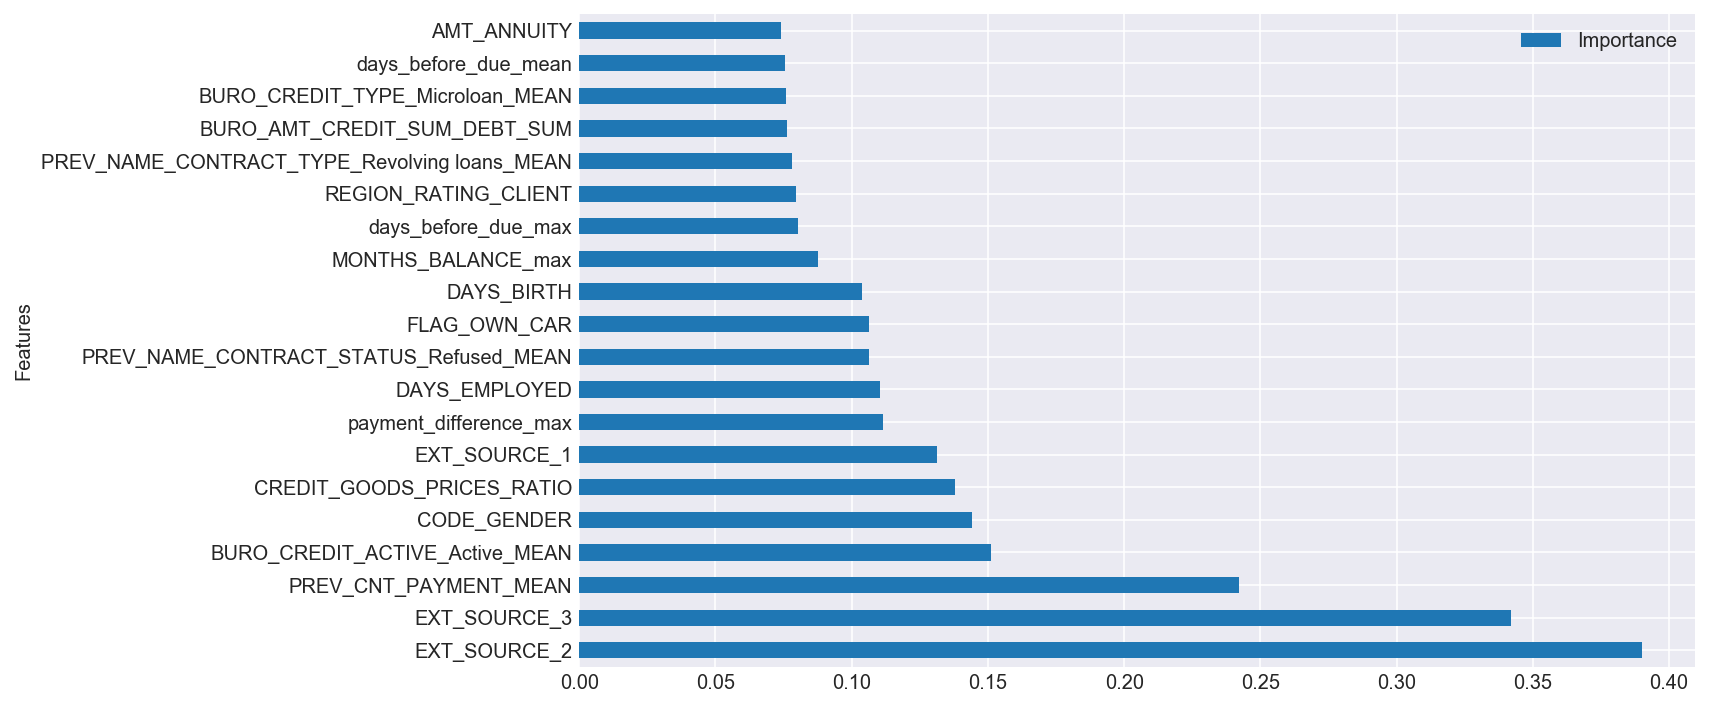

In [47]:
# Plotting
log_reg_coefficients.index = log_reg_coefficients.Features

#plt.figure(figsize=(10,6))
log_reg_coefficients.nlargest(20, columns='Importance').plot(kind='barh', figsize = (10,6))

----------------------------------

## Random Forest Classifier

Random Forest is a popular and versatile machine learning method that is capable of solving both regression and classification. Random Forest is a brand of Ensemble learning, as it relies on an ensemble of decision trees. It aggregates Classification (or Regression) Trees. A decision tree is composed of a series of decisions that can be used to classify an observation in a dataset.

Random Forest fits a number of decision tree classifiers on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting. Random Forest can handle a large number of features, and is helpful for estimating which of your variables are important in the underlying data being modeled.

Random Forest can be implemented using Python's sklearn library (ie sklearn.ensemble.RandomForestClassifier). A number of parameters are provided by defaults by sklearn (see below) such as:

- number of estimators (ie number of trees in the forest)
- max_features (ie number of features to consider when looking for the best split)
- min_samples_leaf (ie minimum number of samples required to be at a leaf node)

In [27]:
gc.collect()
param_grid = { 
    'n_estimators': [20, 40],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [4, 6]
}

rfc_gs=RandomForestClassifier(random_state=42)
CV_rfc = GridSearchCV(RandomForestClassifier(), param_grid, cv = 2, verbose = 1)
CV_rfc.fit(X_train, y_train)

Fitting 2 folds for each of 8 candidates, totalling 16 fits


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:  4.5min finished


GridSearchCV(cv=2, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [20, 40], 'max_features': ['sqrt', 'log2'], 'max_depth': [4, 6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [28]:
CV_rfc.best_score_

0.6894384163047425

In [29]:
CV_rfc.best_params_

{'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 40}

In [30]:
best_rfc = CV_rfc.best_estimator_
best_score_rfc = roc_auc_score(y_test, best_rfc.predict(X_test))
print("Overall ROC-AUC score using Random Forest Classifier: {:.3f}" .format(best_score_rfc))

Overall ROC-AUC score using Random Forest Classifier: 0.676


In [37]:
cm_best_rfc = pd.DataFrame(metrics.confusion_matrix(y_test, best_rfc.predict(X_test)), columns=['Predicted 0', 'Predicted 1'], index= ['True 0', 'True 1'])
cm_best_rfc

,Predicted 0,Predicted 1
True 0,47258,23363
True 1,1988,4268


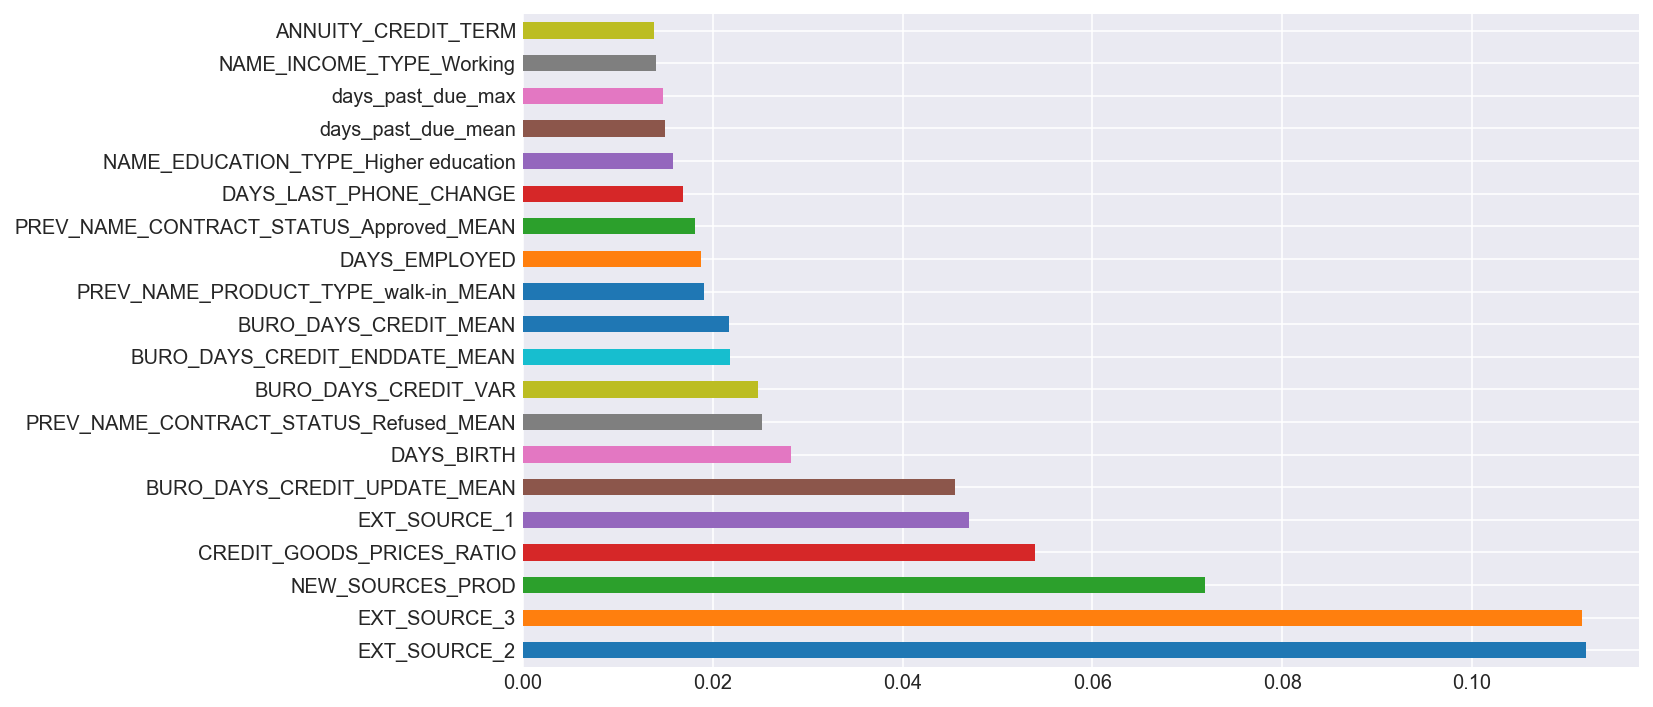

In [43]:
plt.figure(figsize=(10,6))
#X = df.drop(columns= ['SK_ID_CURR','TARGET'])
feat_importances_rfc = pd.Series(best_rfc.feature_importances_, index=X.columns).sort_values(ascending=False)
feat_importances_rfc.nlargest(20).plot(kind='barh')

In [41]:
# y_test_pred_rfc = rfc.predict(X_test)
# print('Test score:', accuracy_score(y_test, y_test_pred_rfc))
# score on test set -- result same as above
# print('Random Forest test score:' , rfc.score(X_test,y_test))

-------------------------------------------------

## Naive Bayes: sklearn.naive_bayes.GaussianNB for continuous features

In [14]:
gnb = GaussianNB()
gnb.fit(X_train_std, y_train)

GaussianNB(priors=None)

In [15]:
# auc-roc score 

score_gbn = roc_auc_score(y_test, gnb.predict(X_test_std))
print("AUC_ROC score using Gaussian Naive Bayes: {:.3f}" .format(score_gbn))

AUC_ROC score using Gaussian Naive Bayes: 0.609


In [50]:
# confusion matrix 
#print(metrics.confusion_matrix(y, y_pred_rfc))
cm_gbn = pd.DataFrame(metrics.confusion_matrix(y_test, gnb.predict(X_test_std)), columns=['Predicted 0', 'Predicted 1'], index= ['True 0', 'True 1'])
cm_gbn

,Predicted 0,Predicted 1
True 0,32389,38232
True 1,1503,4753


In [ ]:
# Feature Importance

## Light GBM

Light GBM is a fast, distributed, high-performance gradient boosting framework based on decision tree algorithm, used for ranking, classification and many other machine learning tasks. 

Released from Microsoft, this algorithm has been claimed to be more efficient (better predictive performance for the same running time) than xgboost.

Light GBM splits the tree leaf wise with the best fit whereas other boosting algorithms split the tree depth wise or level wise rather than leaf-wise. So when growing on the same leaf in Light GBM, the leaf-wise algorithm can reduce more loss than the level-wise algorithm and hence results in much better accuracy which can rarely be achieved by any of the existing boosting algorithms.

Using leaf wise splitting enables it to converge much faster but also leads to overfitting. 

Key parameters in Light GBM are:

- num_iterations: number of boosting iterations to be performed ; default=100; type=int
- num_leaves : number of leaves in one tree ; default = 31 ; type =int
- min_data_in_leaf : Min number of data in one leaf.
- max_depth: Specify the max depth to which tree will grow. This parameter is used to deal with overfitting.

In [51]:
gc.collect()

744

In [52]:
train_data=lgb.Dataset(X_train,label=y_train)
test_data=lgb.Dataset(X_test,label=y_test)

In [53]:
params = {
    'boosting_type': 'gbdt', # traditional Gradient Boosting Decision Tree
    'objective': 'binary',
    'metric': 'auc',
    'metric_freq': 1,
    'is_training_metric': True,
    'max_bin': 255,
    'learning_rate': 0.1,
    'num_leaves': 70,
    'tree_learner': 'serial',
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'min_data_in_leaf': 50,
    'min_sum_hessian_in_leaf': 5,
    'is_enable_sparse': True,
    'use_two_round_loading': False,
    'is_save_binary_file': False,
    'num_machines': 1,
    'verbose': 0,
    'subsample_for_bin': 200000,
    'min_child_samples': 20,
    'min_child_weight': 0.001,
    'min_split_gain': 0.0,
    'colsample_bytree': 1.0,
    'reg_alpha': 0.0,
    'reg_lambda': 0.0
}

In [54]:
clf_lgb = lgb.train(params, train_data, 200, valid_sets=test_data, early_stopping_rounds= 40, verbose_eval= 10)

Training until validation scores don't improve for 40 rounds.
[10]	valid_0's auc: 0.746109
[20]	valid_0's auc: 0.758623
[30]	valid_0's auc: 0.765562
[40]	valid_0's auc: 0.769913
[50]	valid_0's auc: 0.772833
[60]	valid_0's auc: 0.77379
[70]	valid_0's auc: 0.775611
[80]	valid_0's auc: 0.777074
[90]	valid_0's auc: 0.777616
[100]	valid_0's auc: 0.778007
[110]	valid_0's auc: 0.778248
[120]	valid_0's auc: 0.778158
[130]	valid_0's auc: 0.777929
[140]	valid_0's auc: 0.777771
Early stopping, best iteration is:
[104]	valid_0's auc: 0.778407


In [55]:
# auc-roc score on test set
score_lgb = roc_auc_score(y_test, clf_lgb.predict(X_test))
print("Overall ROC-AUC score using LightGBM: {:.3f}" .format(score_lgb))

Overall ROC-AUC score using LightGBM: 0.778


In [56]:
# confusion matrix
y_pred_lgb = clf_lgb.predict(X_test)
y_pred_lgb_binary = [0 if val <= 0.5 else 1 for val in y_pred_lgb]
cm_lgb = pd.DataFrame(metrics.confusion_matrix(y_test, y_pred_lgb_binary), columns=['Predicted 0', 'Predicted 1'], index= ['True 0', 'True 1'])
cm_lgb

,Predicted 0,Predicted 1
True 0,53719,16902
True 1,2137,4119


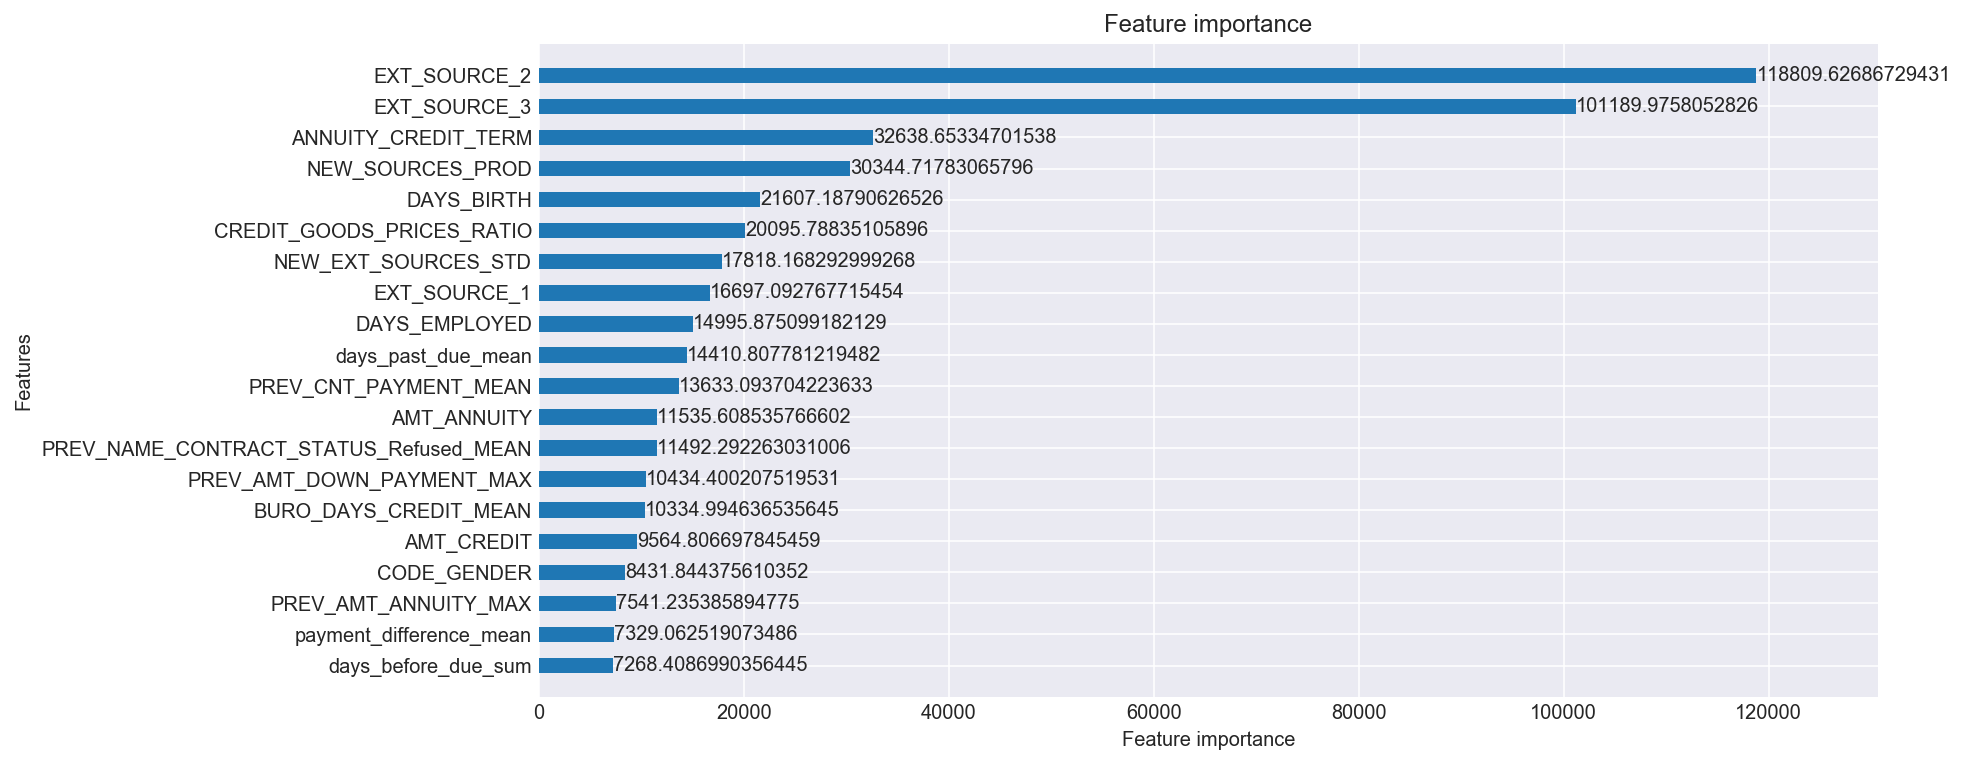

In [57]:
# Feature Importance using LightGBM: top-20 features
lgb.plot_importance(clf_lgb, height=0.5, max_num_features=20, ignore_zero = False, figsize = (12,6), importance_type ='gain')

## XGBoost

XGBoost stands for “Extreme Gradient Boosting”.

XGBoost is an implementation of gradient boosted decision trees designed for speed and performance.

The XGBoost library implements the gradient boosting decision tree algorithm.

This algorithm goes by lots of different names such as gradient boosting, multiple additive regression trees, stochastic gradient boosting or gradient boosting machines.

Boosting is an ensemble technique where new models are added to correct the errors made by existing models. Models are added sequentially until no further improvements can be made. A popular example is the AdaBoost algorithm that weights data points that are hard to predict.

Gradient boosting is an approach where new models are created that predict the residuals or errors of prior models and then added together to make the final prediction. It is called gradient boosting because it uses a gradient descent algorithm to minimize the loss when adding new models.

This approach supports both regression and classification predictive modeling problems.

In [58]:
# XGBOOST Efficient Feature Storage
import xgboost as xgb
feat_names = X.columns
d_train = xgb.DMatrix(X_train, y_train, feature_names=feat_names)
d_test = xgb.DMatrix(X_test, y_test, feature_names=feat_names)

n_rounds = 100
watchlist = [(d_train, 'train')]
xgb_params = {'eta': 0.01, 
              'max_depth': 6, 
              'subsample': 0.8, 
              'colsample_bytree': 0.632,
              'min_child_weight' : 35,
              #'scale_pos_weight': ,
              'objective': 'binary:logistic', 
              'eval_metric': 'auc', 
              'seed': 23,
              'lambda': 0.50,
              'alpha': 0.25,
              'silent': 1
             }

model = xgb.train(xgb_params, d_train, n_rounds, watchlist, verbose_eval=10, early_stopping_rounds=30)

[0]	train-auc:0.688618
Will train until train-auc hasn't improved in 30 rounds.
[10]	train-auc:0.754312
[20]	train-auc:0.755749
[30]	train-auc:0.758177
[40]	train-auc:0.762613
[50]	train-auc:0.763803
[60]	train-auc:0.766084
[70]	train-auc:0.768221
[80]	train-auc:0.769828
[90]	train-auc:0.771398
[99]	train-auc:0.772969


In [59]:
y_pred_xgb= model.predict(d_test)
score_xgb = roc_auc_score(y_test, y_pred_xgb)
print("AUC_ROC score using XGBoost: {:.3f}" .format(score_xgb))

AUC_ROC score using XGBoost: 0.750


**In the second round, I set the number of rounds (number of boosting iterations) to 200**

In [60]:
## try again with n_rounds = 200
n_rounds = 200
xgb_params_2 = {'eta': 0.01, 
              'max_depth': 6, 
              'subsample': 0.8, 
              'colsample_bytree': 0.632,
              'min_child_weight' : 35,
              #'scale_pos_weight': ,
              'objective': 'binary:logistic', 
              'eval_metric': 'auc', 
              'seed': 23,
              'lambda': 0.50,
              'alpha': 0.25,
              'silent': 1
             }

model_2 = xgb.train(xgb_params_2, d_train, n_rounds, watchlist, verbose_eval=10, early_stopping_rounds=30)

[0]	train-auc:0.688618
Will train until train-auc hasn't improved in 30 rounds.
[10]	train-auc:0.754312
[20]	train-auc:0.755749
[30]	train-auc:0.758177
[40]	train-auc:0.762613
[50]	train-auc:0.763803
[60]	train-auc:0.766084
[70]	train-auc:0.768221
[80]	train-auc:0.769828
[90]	train-auc:0.771398
[100]	train-auc:0.772999
[110]	train-auc:0.774668
[120]	train-auc:0.77642
[130]	train-auc:0.778037
[140]	train-auc:0.779426
[150]	train-auc:0.780826
[160]	train-auc:0.782217
[170]	train-auc:0.783663
[180]	train-auc:0.785155
[190]	train-auc:0.786761
[199]	train-auc:0.787856


In [61]:
y_pred_xgb_2= model_2.predict(d_test)
score_xgb_2 = roc_auc_score(y_test, y_pred_xgb_2)
print("AUC_ROC score using XGBoost with 200 rounds: {:.3f}" .format(score_xgb_2))

AUC_ROC score using XGBoost with 200 rounds: 0.759


In [62]:
y_pred_xgb_2

array([0.637399  , 0.23598713, 0.5259624 , ..., 0.7204866 , 0.5001989 ,
       0.25819153], dtype=float32)

In [63]:
# confusion matrix
y_pred_xgb_binary = [0 if val <= 0.5 else 1 for val in y_pred_xgb_2]
cm_xgb = pd.DataFrame(metrics.confusion_matrix(y_test, y_pred_xgb_binary), columns=['Predicted 0', 'Predicted 1'], index= ['True 0', 'True 1'])
cm_xgb

,Predicted 0,Predicted 1
True 0,49100,21521
True 1,1946,4310


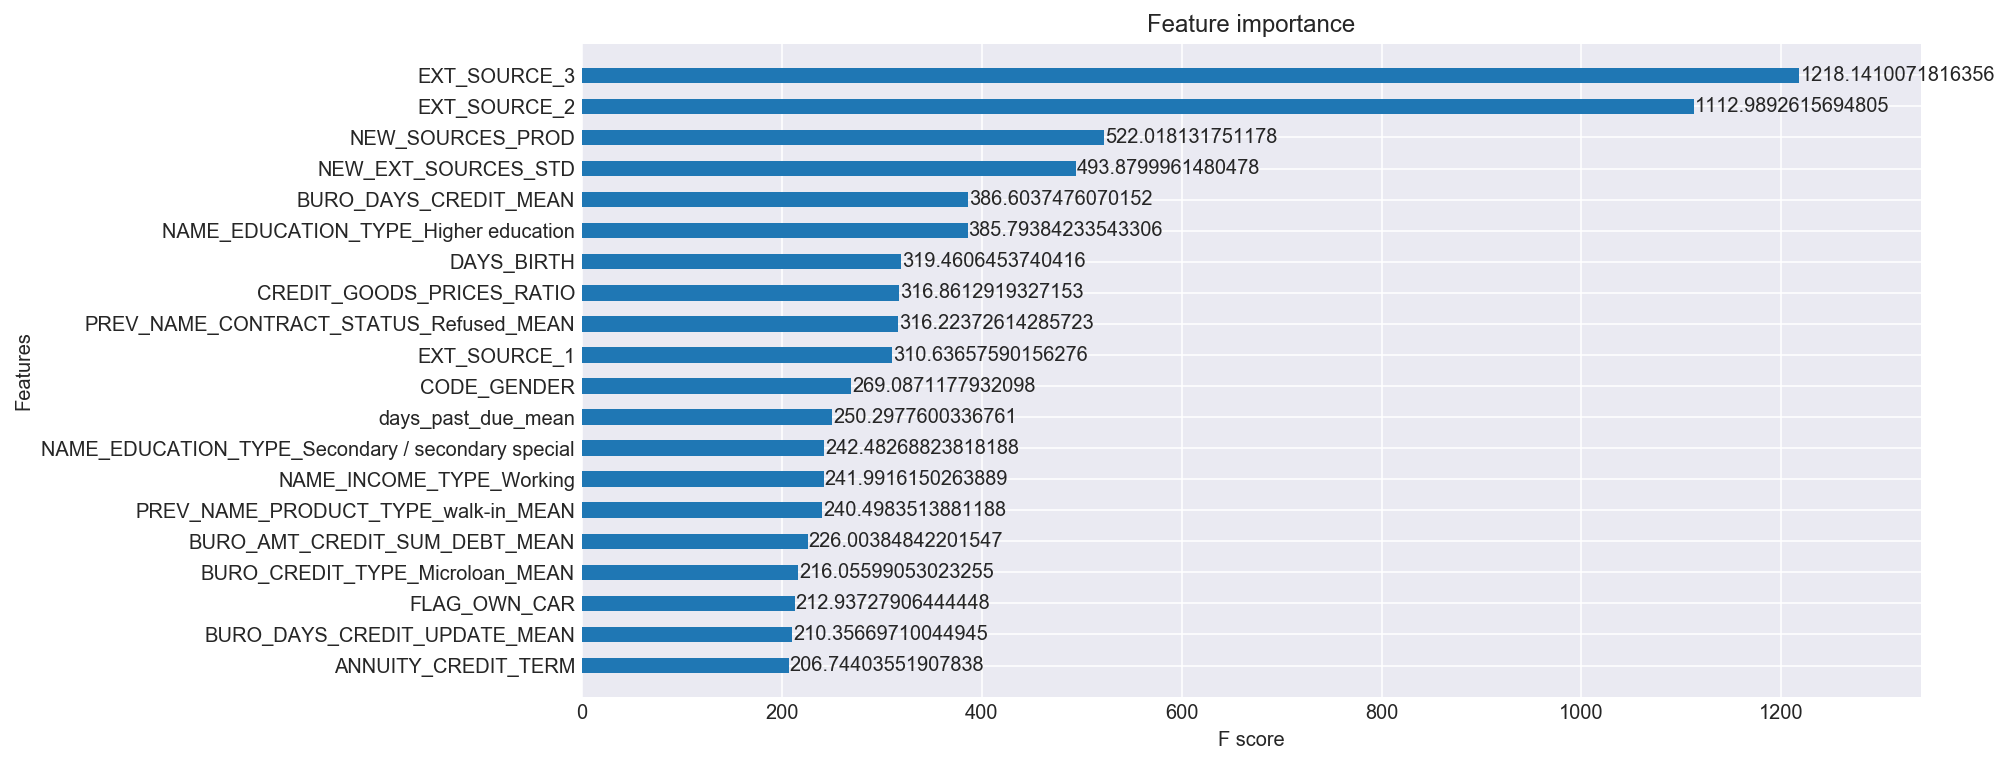

In [64]:
# Feature Inportance
fig, ax = plt.subplots(figsize=(12, 6))
xgb.plot_importance(model_2, height=0.5, max_num_features=20, importance_type ='gain', ax=ax)

---------------------------------------------------

## XGBClassifier

xgboost.XGBClassifier is a Scikit-Learn Wrapper interface for XGBoost.

    Note: xgb.train(objective='binary:logistic').predict() is equivalent to xgb.XGBClassifier().predict_probab(). 

In [65]:
gc.collect()
from xgboost import XGBClassifier
xgbc = XGBClassifier(
        objective="binary:logistic",
        booster="gbtree",
        eval_metric = "auc",
        nthread = 4,
        eta = 0.05,
        gamma = 0,
        max_depth = 6,
        subsample=0.7,
        colsample_bytree = 0.7,
        colsample_bylevel = 0.675,
        min_child_weight = 22,
        alpha = 0.25,
        random_state = 42,
        nrounds = 100
)

xgbc.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=20, early_stopping_rounds=30)

[0]	validation_0-auc:0.702516	validation_1-auc:0.684626
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[20]	validation_0-auc:0.784634	validation_1-auc:0.756624
[40]	validation_0-auc:0.807185	validation_1-auc:0.766282
[60]	validation_0-auc:0.822607	validation_1-auc:0.771787
[80]	validation_0-auc:0.833401	validation_1-auc:0.774523
[99]	validation_0-auc:0.842238	validation_1-auc:0.7763


XGBClassifier(alpha=0.25, base_score=0.5, booster='gbtree',
       colsample_bylevel=0.675, colsample_bytree=0.7, eta=0.05,
       eval_metric='auc', gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=22, missing=None, n_estimators=100,
       n_jobs=1, nrounds=100, nthread=4, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.7)

In [66]:
# Overall Accuracy
y_pred_xgbc = xgbc.predict(X_test)
score_xgbc = roc_auc_score(y_test, y_pred_xgbc)
print("ROC-AUC score using XGBClassifier: {:.3f}" .format(score_xgbc))

ROC-AUC score using XGBClassifier: 0.708


C:\Users\HaNguyen\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# Model Evaluation & Inference

In this section, I'll compare the performance of these above classification. 

Let's have a look at a summary table of the AUC_ROC scores for every algorithms

In [5]:
d = {'1. Logistic Regression': [0.694], 
     '2. Random Forest': [0.676],
     '3. Gaussian Naive Bayes':[0.609],
     '4. Light GBM': [0.778], 
     '5. XGBoost': [0.759],
     '6. XGBClassifier': [0.708]}
d_inds = ['AUC ROC Score']
df_results = pd.DataFrame(data=d, index = d_inds)
df_results = df_results.transpose()
df_results

,AUC ROC Score
1. Logistic Regression,0.694
2. Random Forest,0.676
3. Gaussian Naive Bayes,0.609
4. Light GBM,0.778
5. XGBoost,0.759
6. XGBClassifier,0.708


In [17]:
d2 = {'Rank 1 feature': ['EXT_SOURCE_2','EXT_SOURCE_2','EXT_SOURCE_2','EXT_SOURCE_3'],
      'Rank 2 feature': ['EXT_SOURCE_3', 'EXT_SOURCE_3','EXT_SOURCE_3','EXT_SOURCE_2'],
      'Rank 3 feature': ['PREV_CNT_PAYMENT_MEAN','NEW_SOURCES_PROD','ANNUITY_CREDIT_TERM','NEW_SOURCES_PROD'],
      'Rank 4 feature': ['BURO_CREDIT_ACTIVE_Active_MEAN','CREDIT_GOODS_PRICES_RATIO','NEW_SOURCES_PROD','NEW_EXT_SOURCES_STD'],
      'Rank 5 feature': ['CODE_GENDER', 'EXT_SOURCE_1','DAYS_BIRTH','BURO_DAYS_CREDIT_MEAN']}

d2_inds = ['Logistic Regression', 'Random Forest', 'LightGBM', 'XGBoost']

df2_results = pd.DataFrame(data=d2, index = d2_inds)
df2_results = df2_results.transpose()
df2_results

,Logistic Regression,Random Forest,LightGBM,XGBoost
Rank 1 feature,EXT_SOURCE_2,EXT_SOURCE_2,EXT_SOURCE_2,EXT_SOURCE_3
Rank 2 feature,EXT_SOURCE_3,EXT_SOURCE_3,EXT_SOURCE_3,EXT_SOURCE_2
Rank 3 feature,PREV_CNT_PAYMENT_MEAN,NEW_SOURCES_PROD,ANNUITY_CREDIT_TERM,NEW_SOURCES_PROD
Rank 4 feature,BURO_CREDIT_ACTIVE_Active_MEAN,CREDIT_GOODS_PRICES_RATIO,NEW_SOURCES_PROD,NEW_EXT_SOURCES_STD
Rank 5 feature,CODE_GENDER,EXT_SOURCE_1,DAYS_BIRTH,BURO_DAYS_CREDIT_MEAN


In [ ]:
# app_train['NEW_SOURCES_PROD'] = app_train['EXT_SOURCE_1'] * app_train['EXT_SOURCE_2'] * app_train['EXT_SOURCE_3']

In [ ]:
# app_train['NEW_EXT_SOURCES_STD'] = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)